In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Dataset/data.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/data/train/present/UID_35_10_3_all.jpg  
  inflating: /content/data/data/train/present/UID_35_10_5_all.jpg  
  inflating: /content/data/data/train/present/UID_35_10_6_all.jpg  
  inflating: /content/data/data/train/present/UID_35_10_7_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_10_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_1_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_2_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_4_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_5_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_8_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_10_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_11_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_1_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_2_all.

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
train_path = "/content/data/data/train"
val_path = "/content/data/data/validation"
test_path = "/content/data/data/test"

In [ ]:
IMAGE_SIZE = [224,224]

In [ ]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255,
    rotation_range=30,           # Rotate images by up to 30 degrees
    width_shift_range=0.05,       # Translate horizontally by 20% of the width
    height_shift_range=0.05,      # Translate vertically by 20% of the height
    shear_range=0.1,             # Apply shear transformation
    zoom_range=0.1,              # Random zoom by up to 20%
    horizontal_flip=True,        # Flip images horizontally
    brightness_range=[0.8, 1.2],)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(224,224),
                                              batch_size=16,
                                              class_mode = 'categorical')

val_set = train_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(224,224),
                                            batch_size=16,
                                            class_mode='categorical')

Found 9616 images belonging to 2 classes.
Found 2062 images belonging to 2 classes.
Found 2060 images belonging to 2 classes.


In [ ]:

from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [ ]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

In [ ]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

# EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
steps_per_epoch = train_set.samples // train_set.batch_size
validation_steps = test_set.samples // test_set.batch_size

# Add 1 if there are leftover samples
steps_per_epoch += int(train_set.samples % train_set.batch_size != 0)
validation_steps += int(test_set.samples % test_set.batch_size != 0)


In [ ]:
x_batch, y_batch = next(train_set)
print(f"Train batch shape: {x_batch.shape}, Labels shape: {y_batch.shape}")

x_batch, y_batch = next(test_set)
print(f"Test batch shape: {x_batch.shape}, Labels shape: {y_batch.shape}")


Train batch shape: (16, 224, 224, 3), Labels shape: (16, 2)
Test batch shape: (16, 224, 224, 3), Labels shape: (16, 2)


In [ ]:
eff = EfficientNetB0(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

x1 = Flatten()(eff.output)
prediction1 = Dense(2, activation='softmax')(x1)
model3 = Model(inputs=eff.input, outputs=prediction1)

# Compile the model first
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy", f1_m, precision_m, recall_m])

# Then print model summary
model3.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,175,013 (15.93 MB)

 Trainable params: 4,132,990 (15.77 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
hist3 = model3.fit(
    train_set,
    validation_data=val_set,
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[learning_rate_reduction, early_stop]
)


Epoch 1/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 264s 315ms/step - accuracy: 0.7566 - f1_m: 0.7566 - loss: 1.3129 - precision_m: 0.7566 - recall_m: 0.7566 - val_accuracy: 0.4961 - val_f1_m: 0.4960 - val_loss: 2.4588 - val_precision_m: 0.4960 - val_recall_m: 0.4960 - learning_rate: 0.0010
Epoch 2/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 177s 294ms/step - accuracy: 0.8424 - f1_m: 0.8424 - loss: 0.4722 - precision_m: 0.8424 - recall_m: 0.8424 - val_accuracy: 0.4806 - val_f1_m: 0.4807 - val_loss: 428.9986 - val_precision_m: 0.4807 - val_recall_m: 0.4807 - learning_rate: 0.0010
Epoch 3/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 201s 293ms/step - accuracy: 0.8488 - f1_m: 0.8488 - loss: 0.4118 - precision_m: 0.8488 - recall_m: 0.8488 - val_accuracy: 0.5000 - val_f1_m: 0.4999 - val_loss: 2.8891 - val_precision_m: 0.4999 - val_recall_m: 0.4999 - learning_rate: 0.0010
Epoch 4/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 202s 292ms/step - accuracy: 0.8330 - f1_m: 0.8330 - loss: 0.5094 - precision_m: 0.8330 - recall_m: 0.8330 - val_accura

In [ ]:
model3.save(f"/content/drive/MyDrive/{'EfficientNetb0'}.h5")


In [ ]:
from google.colab import files
files.download(f"/content/drive/MyDrive/EfficientNetb0.h5")  # For .h5 file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
scores = model3.evaluate(test_set)
storeResults("EfficientNetb0", scores[1], scores[2], scores[3], scores[4])

129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.9351 - f1_m: 0.9351 - loss: 0.1839 - precision_m: 0.9351 - recall_m: 0.9351


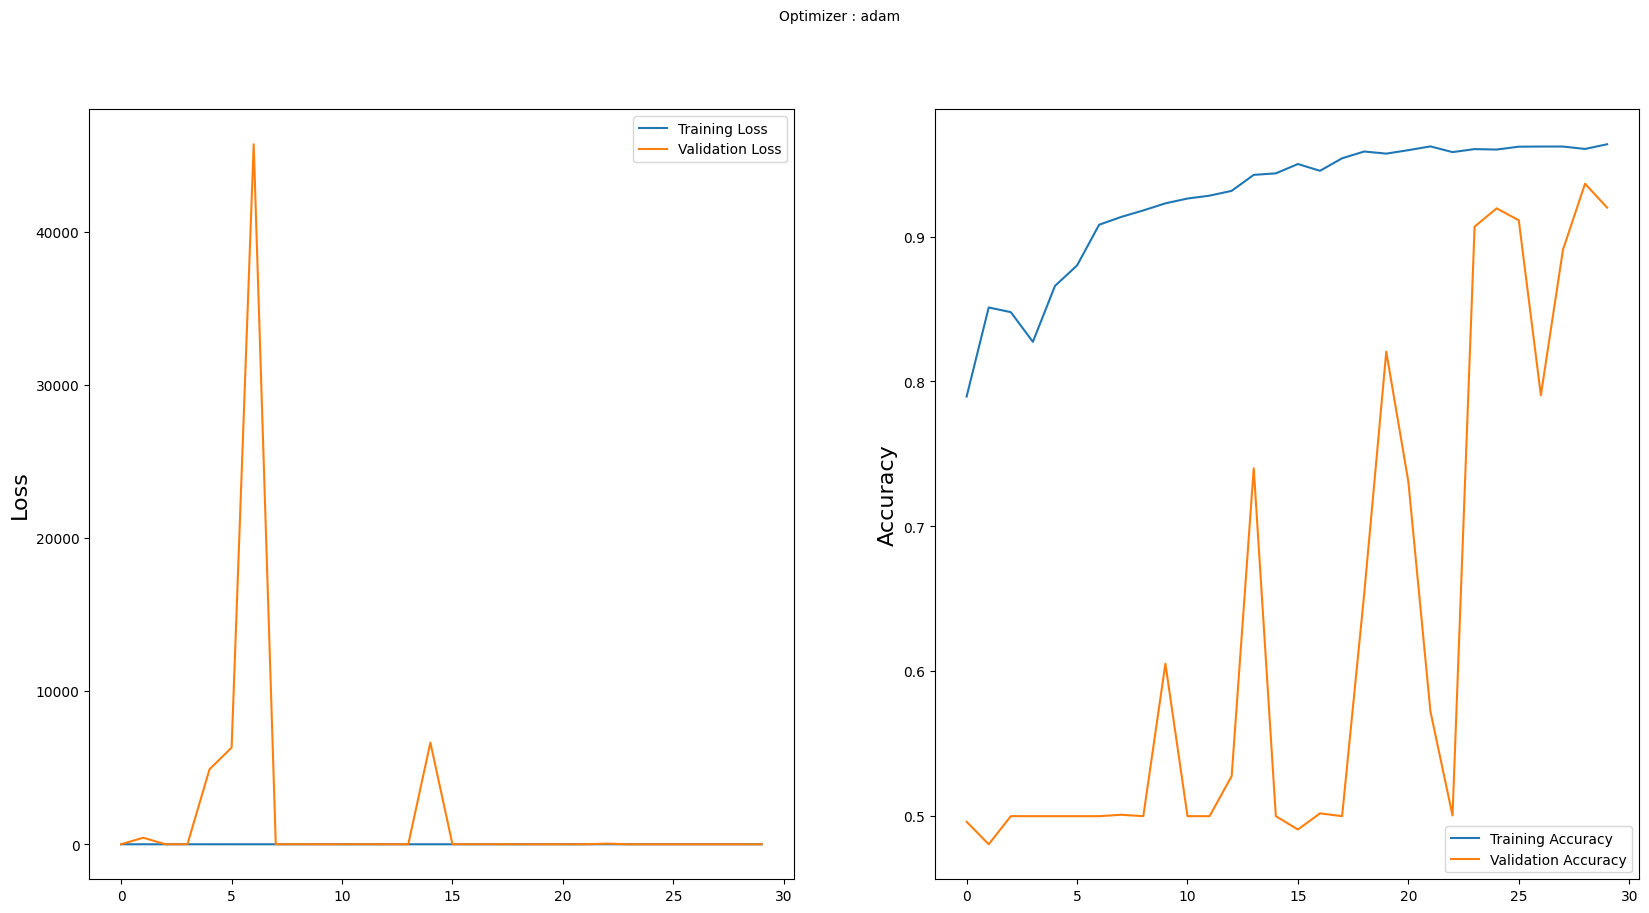

In [ ]:
import matplotlib.pyplot as plt

x=hist3
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Save training history to a JSON file
import json
history_dict = hist3.history
with open(f"/content/drive/MyDrive/{'EfficientNetb0'}_history.json", "w") as f:
    json.dump(history_dict, f)



In [ ]:
print(hist3.history['accuracy'][19])
print(hist3.history['precision_m'][19])
print(hist3.history['recall_m'][19])
print(hist3.history['f1_m'][19])


0.9572587609291077
0.9572587609291077
0.9572587609291077
0.9572587609291077
